In [ ]:
# ----------------------------------------
# filename model_interpretability.ipynb
# author Partha Deka
# revision 1.0
# revision history 1.0 - initial script

## Using XGBoost's Feature Importance with the Boston Housing Dataset

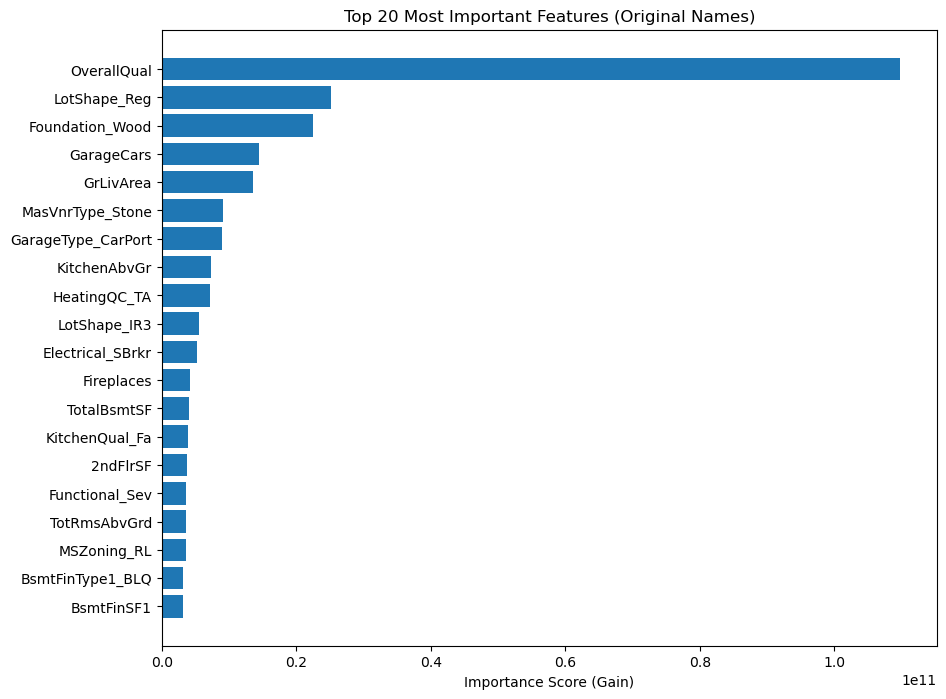

In [5]:
import xgboost as xgb
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import os

os.environ['HTTP_PROXY'] = 'http://proxy-us.intel.com:911'
os.environ['HTTPS_PROXY'] = 'http://proxy-us.intel.com:912'


# Load the Boston Housing dataset
data = fetch_openml(name="house_prices", as_frame=True)
housing_data = data.frame

# Handle categorical variables by converting them to numeric using pd.get_dummies
housing_data_encoded = pd.get_dummies(housing_data)

# Extract original feature names
original_feature_names = housing_data_encoded.columns

# Split the data into features (X) and target (y)
X = housing_data_encoded.drop(columns=["SalePrice"])
y = housing_data_encoded["SalePrice"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for optimal performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train_scaled, y_train)

# Retrieve feature importance scores and map them back to original feature names
importance_dict = model.get_booster().get_score(importance_type='gain')

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': [original_feature_names[int(key[1:])] for key in importance_dict.keys()],
    'Importance': importance_dict.values()
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 20 most important features with original names
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.title("Top 20 Most Important Features (Original Names)")
plt.xlabel("Importance Score (Gain)")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


## Using SHAP with the Boston Housing Dataset

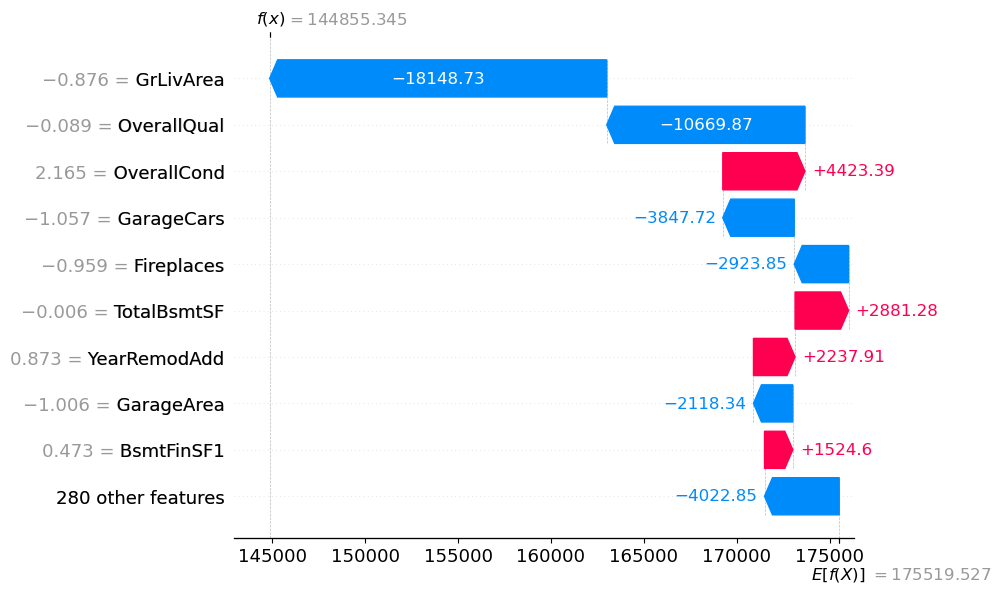

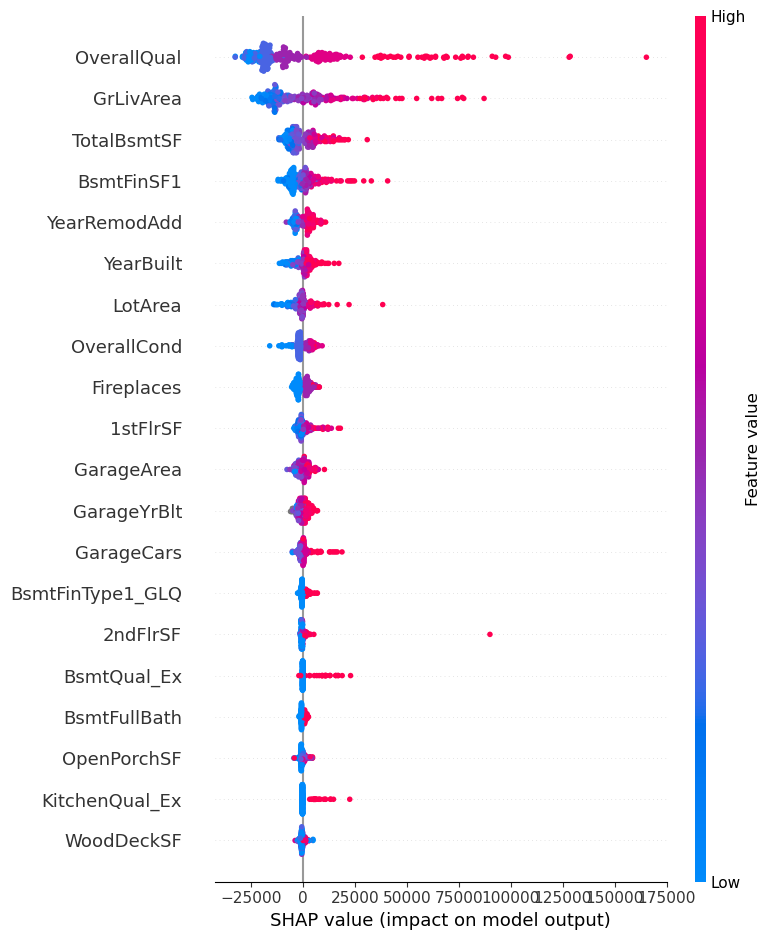

In [8]:
import shap
import pandas as pd

# Create a DataFrame for the scaled X_test with proper feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Initialize SHAP explainer using the model and the scaled training data
explainer = shap.Explainer(model, X_train_scaled, feature_names=X_train.columns)

# Compute SHAP values for the test set
shap_values = explainer(X_test_scaled)

# SHAP Waterfall plot for a single prediction (now no need for feature_names parameter)
shap.waterfall_plot(shap_values[0])

# SHAP Summary plot for global feature importance (uses the DataFrame to preserve feature names)
shap.summary_plot(shap_values, X_test_scaled_df)


In [12]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd

# Define a wrapper for model.predict to ensure it uses scaled data
def predict_fn(x):
    x_scaled = scaler.transform(x)  # Scale the data before predicting
    return model.predict(x_scaled).flatten()  # Ensure the output is 1D for LIME

# Initialize LIME explainer using the unscaled training data
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,  # Use unscaled data
    feature_names=X_train.columns, 
    mode='regression',
    discretize_continuous=False  # Disable discretization for continuous features
)

# Explain a single instance (e.g., the first test instance)
i = 0
exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=5)

# Show the explanation
exp.show_in_notebook(show_table=True)


C:\ProgramData\miniforge3\envs\xgboost_miniforge\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
